In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt # Tesseract, yani harfleri resimden çıkarmak için önceden edğitilmiş bir kütüphane.
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
path = glob('../input/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[]) # Bir kütüphane oluşturuyor.
for filename in path:

    info = xet.parse(filename) # Bu kütüphane xml leri okumak için kullanılıyor.
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox') # bndbox xml de bir yer koda bakarsan anlaşılıyor. Sanırım bu 3 satır verinin yerini göstermek için var.
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/number-plate-detection/images/N148.xml,244,369,240,293
1,../input/number-plate-detection/images/N177.xml,331,538,263,317
2,../input/number-plate-detection/images/N173.xml,80,335,150,243
3,../input/number-plate-detection/images/N213.xml,131,209,129,153
4,../input/number-plate-detection/images/N119.xml,180,559,216,314


In [4]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../input/number-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../input/number-plate-detection/images/N148.jpeg'

In [5]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]# Rastgele 10 tanesini seçtik

['../input/number-plate-detection/images/N148.jpeg',
 '../input/number-plate-detection/images/N177.jpeg',
 '../input/number-plate-detection/images/N173.jpeg',
 '../input/number-plate-detection/images/N213.jpeg',
 '../input/number-plate-detection/images/N119.jpeg',
 '../input/number-plate-detection/images/N103.jpeg',
 '../input/number-plate-detection/images/N166.jpeg',
 '../input/number-plate-detection/images/N127.jpeg',
 '../input/number-plate-detection/images/N162.jpeg',
 '../input/number-plate-detection/images/N198.jpeg']

<p id="part10"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">2.5 VERİLERİ DOĞRULAYIN</span>



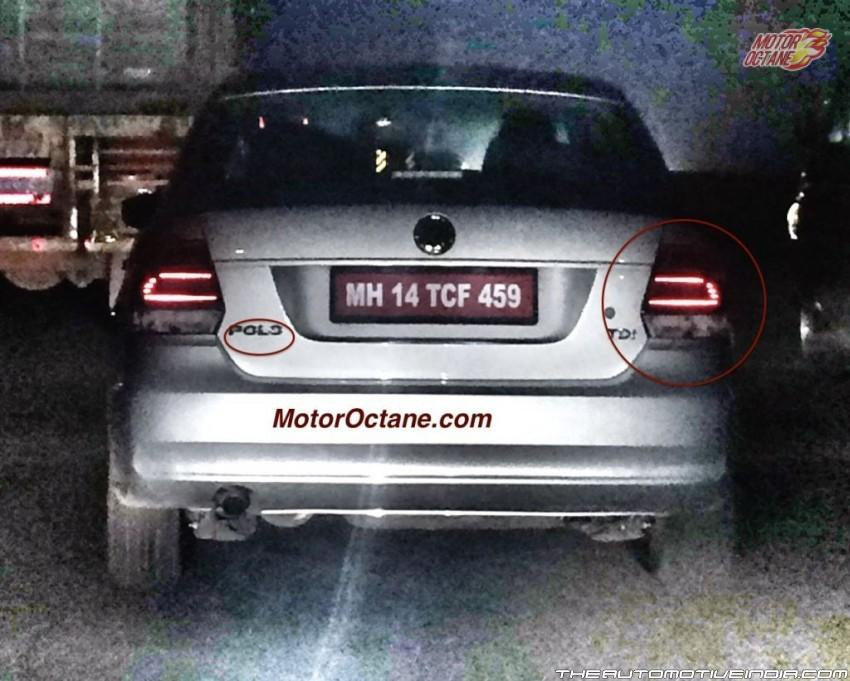

In [6]:
file_path = image_path[1] # resmimizin yolu N2.jpeg. Resmi değiştirirsen alttaki konumları da değiştirmelisin.
#img = cv2.imread(file_path) # Resmi oku. Bu kısım neden ver analmadım olmayınca da çalışıyor.
img = io.imread(file_path) # Resmi oku
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=331, x1=538, y0=263, y1=317, xref='x', yref='y',line_color='cyan')

<p id="part11"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">3. VERİ ÖNİŞLEME </span>



In [7]:
# Tüm sütunları seçerek dizideki tüm değerlerimizi hedefleme
labels = df.iloc[:,1:].values # dosya yolu isimini veren sütun hariç bütün sütunları alıyor. 
data = []
output = []
for ind in range(len(image_path)): # range 0 dan istenilen sayıya kadar sayılar oluşturur 0 1 2 3 ... gibi.
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [8]:
# Convert data to array
X = np.array(data,dtype=np.float32) # data resimleri boyutlandırılmış hali
y = np.array(output,dtype=np.float32) # output plakanın konumu

In [9]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))


Öyleyse, resmimin şekline bakalım.

In [10]:
#image_arr_224.shape

In [11]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../input/number-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,../input/number-plate-detection/images/N148.xml,244,369,240,293,../input/number-plate-detection/images/N148.jpeg,600,430
1,../input/number-plate-detection/images/N177.xml,331,538,263,317,../input/number-plate-detection/images/N177.jpeg,850,681
2,../input/number-plate-detection/images/N173.xml,80,335,150,243,../input/number-plate-detection/images/N173.jpeg,445,349
3,../input/number-plate-detection/images/N213.xml,131,209,129,153,../input/number-plate-detection/images/N213.jpeg,350,196
4,../input/number-plate-detection/images/N119.xml,180,559,216,314,../input/number-plate-detection/images/N119.jpeg,678,475


In [12]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,../input/number-plate-detection/images/N148.xml,244,369,240,293,../input/number-plate-detection/images/N148.jpeg,600,430,0.510833,0.619767,0.208333,0.123256
1,../input/number-plate-detection/images/N177.xml,331,538,263,317,../input/number-plate-detection/images/N177.jpeg,850,681,0.511176,0.425844,0.243529,0.079295
2,../input/number-plate-detection/images/N173.xml,80,335,150,243,../input/number-plate-detection/images/N173.jpeg,445,349,0.466292,0.563037,0.573034,0.266476
3,../input/number-plate-detection/images/N213.xml,131,209,129,153,../input/number-plate-detection/images/N213.jpeg,350,196,0.485714,0.719388,0.222857,0.122449
4,../input/number-plate-detection/images/N119.xml,180,559,216,314,../input/number-plate-detection/images/N119.jpeg,678,475,0.544985,0.557895,0.558997,0.206316


<p id="part35"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.2 VERİ HAZIRLAMA</span>




In [13]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15647, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 15647 (delta 130), reused 177 (delta 102), pack-reused 15393
Receiving objects: 100% (15647/15647), 14.65 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (10654/10654), done.


In [14]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
  Attempting uninstall: gitpython
    Found existing installation: GitPython 3.1.27
    Uninstalling GitPython-3.1.27:
      Successfully uninstalled GitPython-3.1.27
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.16 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.2.0 which is incompatible.
spacy 3.2.4 requires typing-ex

Bir klasör daha oluşturmamız ve içine iki tane daha yapmamız gerekiyor - onu data_images olarak adlandırın ve eğitin ve test edin. Verileri eğitmek ve bölmek için böleceğiz.


In [15]:
mkdir /kaggle/working/yolov5/data_images/

In [16]:
mkdir /kaggle/working/yolov5/data_images/test/

In [17]:
mkdir /kaggle/working/yolov5/data_images/train/

In [18]:
### veriyi böl
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [19]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1] # ismi ayırmak için kullanılıyor yani direk dosya ismini almak için kullanılmış
    txt_name = os.path.splitext(image_name)[0] # uzantıyı isimden ayırılıyor. Eğer 0 yerine 1 yazsaydı uzantıyı verecekti. Bunun sayesinde sadece dosya ismini alabildik
    
    dst_image_path = os.path.join(train_folder,image_name) # yol bileşenlerini  birleştirir. "./yolov5/data_images/train/0001.txt" gibi bir değerler var içinde.
    dst_label_file = os.path.join(train_folder,txt_name+'.txt') # tam olarak anlamadım burakları dosya yolunu bozuyor bence bu kod ama çözemedim.
    
    # her görüntüyü klasöre kopyalayın
    copy(fname,dst_image_path)

    # etiket bilgisi olan .txt oluştur
    label_txt = f'0 {x} {y} {w} {h}'  # anladığım kadaryla etiket değerlerini hepsini bir txt dosyasına yazmış.
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

Ayrıca __data.yaml__ dosyasını eğitim yolu ve doğrulama ile birlikte sınıf sayısı 1 olarak oluşturacağım, listede plaka olarak adlandırın. Bunu veri kümenize kaydetmeniz gerekecek çünkü daha sonra bunun üzerindeki yolu sağlamamız gerekecek.

```
train: data_images/train
val: data_images/test
nc: 1
names: [
    'license_plate'
]
```

<p id="part36"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.3 TRAINING YOLO</span>


In [20]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("Önbelleği boşalttıktan sonra GPU Kullanımı")
    gpu_usage()

free_gpu_cache()  

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=a0f1982ded15f10930871b6c0ca8a26a9850a385740f8613d6826b0f4717877c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
Önbelleği boşalttıktan sonra GPU Kullanımı
| ID | GPU | MEM |
------------------
|  0 |  8% |  2% |


In [21]:
!python ./yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=../input/number-plate-detection/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval

Model eğitildiğinde, onu OCR'de onnx formatında kullanabilmek için aşağıdaki gibi kaydetmemiz gerekiyor:

In [22]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-163-g016e046 Python-3.7.12 torch-1.11.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.11.0...
TorchScript: export success ✅ 2.9s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [23]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640


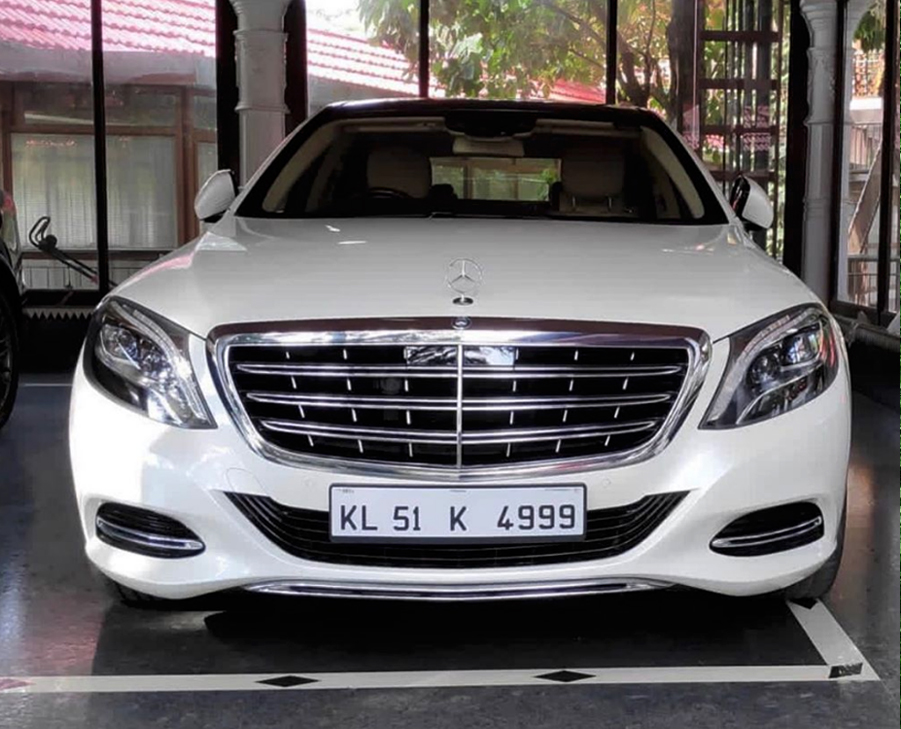

In [24]:
# LOAD THE IMAGE
img = io.imread('../input/number-plate-detection/TEST/TEST.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [25]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/dnn/src/onnx/onnx_importer.cpp:198: error: (-5:Bad argument) Can't read ONNX file: ./yolov5/runs/train/Model/weights/best.onnx in function 'ONNXImporter'


In [ ]:
def get_detections(img,net): # net değişkeni  = yolo modeli
    # 1. GÖRÜNTÜYÜ YOLO FORMATINA DÖNÜŞTÜR
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. YOLO MODELİNDEN TAHMİN ALIN
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. GÜVEN VE OLASILIK Skoruna Dayalı FİLTRE TESPİTLERİ
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # plaka güveni tespit etme
        if confidence > 0.4:
            class_score = row[5] # plaka olasılık puanı
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    print(boxes_np)
    print(confidences_np)
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    print(index.shape)
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [ ]:
# dönüş sonucu ile tahmin akışı
def yolo_predictions(img,net):
    # step-1: detections (tespitler)
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [ ]:
# metin ayıklanıyor
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [ ]:
# test
img = io.imread('../input/number-plate-detection/TEST/TEST.jpeg')
results = yolo_predictions(img,net)

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [ ]:
'''
cap = cv2.VideoCapture('../input/number-plate-detection/TEST/TEST.mp4')
while True:
    ret, frame = cap.read()

    if ret == False:
        print('Unable to read video') # anlamadığım bir nedenden program patlıyor.
        break

    results = yolo_predictions(frame,net)

    cv2.namedWindow('YOLO',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('YOLO',results)
    if cv2.waitKey(30) == 27 :
        break

cv2.destroyAllWindows()
cap.release()
'''

In [ ]:
import cv2
 
# Path to image in local directory
path = '../input/number-plate-detection/TEST/TEST.jpeg'
 
# Using cv2.imread() to read an image in default mode
image = cv2.imread(path)
 
# Using namedWindow()
# A window with 'Display' name is created
# with WINDOW_AUTOSIZE, window size is set automatically
cv2.namedWindow("Display", cv2.WINDOW_AUTOSIZE)
 
# using cv2.imshow() to display the image
cv2.imshow('Display', image)
 
# Waiting 0ms for user to press any key
cv2.waitKey(0)
 
# Using cv2.destroyAllWindows() to destroy
# all created windows open on screen
cv2.destroyAllWindows()

In [ ]:
import pickle
Pkl_Filename = "Pickle_RL_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(Model, file)

In [ ]:
import pickle

filename = 'my_model.h5'
pickle.dump(Model, open(filename, 'wb'))